# OSMI Mental Health Survey Analysis
## Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn import preprocessing
import seaborn as sns
import copy
from notebook.services.config import ConfigManager

# In order to make the notebook look better online limit the maximum number of cell output.
cm = ConfigManager().update('notebook', {'limit_output': 100})

pd.options.mode.chained_assignment = None

In [2]:
healthData = pd.read_csv("mental_health_in_tech.csv")

In [3]:
healthData.head()

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",...,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What country do you live in?,What US state or territory do you live in?,What country do you work in?,What US state or territory do you work in?,Which of the following best describes your work position?,Do you work remotely?
0,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,...,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
1,0,Jun-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,...,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
2,0,Jun-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,...,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Sometimes,Sometimes,43,male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes
4,0,Jun-25,0.0,1.0,Yes,Yes,No,No,No,Neither easy nor difficult,...,Sometimes,Sometimes,43,Female,United States of America,Illinois,United States of America,Illinois,Executive Leadership|Supervisor/Team Lead|Dev ...,Sometimes


It is useful to split self employed out from employed by a big companies due to quantity of NaNs in the self employed rows.

In [4]:
selfData = healthData[healthData["Are you self-employed?"] == 1.0]
autrData = healthData[healthData["Are you self-employed?"] == 0.0]

In [5]:
conversions = {}
def performConversions(inpDict, inpData):
    """Replaces various items in a dataframe using a more concise data structure.
        Args:
            inpDict (dict):
                Dictionary of the conversions to perform.
                Each entry must take the form of a list of a lists, where each list within the list
                swaps the first item with the second.
            inpData (pandas.core.frame.DataFrame):
                The dataframe on which to perform the conversions.
        returns: 
            inpData (pandas.core.frame.DataFrame):
                The updated dataframe.
    """
    
    for key, swaps in inpDict.items():
        print(swaps)
        for item in swaps:
            print("Swapping", item[0], "and", item[1], "in", key)
            inpData[key].replace(item[0], item[1], inplace=True)
            
    return inpData

In [6]:
def findUnique(inpData):
    """Prints all unique values in a column.
        Args:
            inpData (pandas.core.frame.DataFrame):
                The dataframe on which to perform the conversions.
    """
    for column in inpData.keys():
        print(column)
        print(set(inpData[column]), "\n")

In [7]:
print(findUnique(autrData))

Are you self-employed?
{0} 

How many employees does your company or organization have?
{'More than 1000', '26-100', '01-May', '100-500', '500-1000', 'Jun-25'} 

Is your employer primarily a tech company/organization?
{0.0, 1.0} 

Is your primary role within your company related to tech/IT?
{nan, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In order to perform more interesting analysis it is neccessary to convert the dataframe to one hot encoding. This allows techniques such as k-means clustering.


Some columns have very few or no entries when the self employed and others are split, so these are removed. The remaining points with no entry are replaced with "No Answer". Some rows are lost by doing this, as shown by the count, but these are just from the slef employed subset.

In the "Which of the following best describes your work position?" question there are only actually 12 different categories, compared to the originally suggested 182... Need to fix this madness, along with some similar issues with other categories.

In [8]:
print(autrData["Which of the following best describes your work position?"])

0                                      Back-end Developer
1                  Back-end Developer|Front-end Developer
2                                      Back-end Developer
4       Executive Leadership|Supervisor/Team Lead|Dev ...
5       DevOps/SysAdmin|Support|Back-end Developer|Fro...
6                                      Back-end Developer
7              Dev Evangelist/Advocate|Back-end Developer
8              Support|Back-end Developer|One-person shop
10                                    Front-end Developer
11                                   Executive Leadership
12      Supervisor/Team Lead|Dev Evangelist/Advocate|B...
13      DevOps/SysAdmin|Back-end Developer|Front-end D...
14                                               Designer
15                             Other|Executive Leadership
16                                    Front-end Developer
17                                     Back-end Developer
19                 Back-end Developer|Front-end Developer
20            

In [9]:
def splitTypes(inpData, inpColumn, identifier):
    difTypes = inpData[inpColumn]

    types = []
    for i in difTypes:
        if not pd.isna(i):
            for split in i.split("|"):
                types.append(split)
    types = set(types)
    print(types)
    
    print("Splitting", inpColumn, "into", len(set(types)), "different types")
    
    # Need this in case of overlap between different subtypes     
    prefix = identifier + " "
    
    for t in types:
        newColumn = prefix + t
        inpData.loc[:,newColumn] = pd.Series([False for i in range(inpData.shape[0])], index=inpData.index)
#         inpData = inpData.assign(str(newColumn)=False)
        print("Creating new column '" + newColumn + "'")
    
    for index, row in inpData.iterrows():
        if not pd.isna(row[inpColumn]):
            try:
                for t in types:
                    if t in row[inpColumn]:
                        newColumn = prefix + t
                        inpData.at[index, newColumn] = True
            except:
                print("error with", row[inpColumn])
    print("Split complete")
    return inpData, [prefix + t for t in types]

In [10]:
autrData, positionTypes = splitTypes(autrData, "Which of the following best describes your work position?", "Position")
autrData, selfDiagnosedYesTypes = splitTypes(autrData, "If yes, what condition(s) have you been diagnosed with?", "Self diagnosed yes")
autrData, selfDiagnosedMaybeTypes = splitTypes(autrData, "If maybe, what condition(s) do you believe you have?", "Self diagnosed maybe")
autrData, professionalDiagnosedTypes = splitTypes(autrData, "If so, what condition(s) were you diagnosed with?", "Professional diagnosed")

{'DevOps/SysAdmin', 'Other', 'HR', 'Back-end Developer', 'Support', 'Sales', 'One-person shop', 'Executive Leadership', 'Designer', 'Supervisor/Team Lead', 'Front-end Developer', 'Dev Evangelist/Advocate'}
Splitting Which of the following best describes your work position? into 12 different types
Creating new column 'Position DevOps/SysAdmin'
Creating new column 'Position Other'
Creating new column 'Position HR'
Creating new column 'Position Back-end Developer'
Creating new column 'Position Support'
Creating new column 'Position Sales'
Creating new column 'Position One-person shop'
Creating new column 'Position Executive Leadership'
Creating new column 'Position Designer'
Creating new column 'Position Supervisor/Team Lead'
Creating new column 'Position Front-end Developer'
Creating new column 'Position Dev Evangelist/Advocate'
Split complete
{'Autism Spectrum Disorder', 'Seasonal Affective Disorder', 'Anxiety Disorder (Generalized, Social, Phobia, etc)', 'Schizotypal Personality Disord

Split complete


In [11]:
print(autrData["If yes, what condition(s) have you been diagnosed with?"])

0                                                     NaN
1       Anxiety Disorder (Generalized, Social, Phobia,...
2                                                     NaN
4       Anxiety Disorder (Generalized, Social, Phobia,...
5       Anxiety Disorder (Generalized, Social, Phobia,...
6                                                     NaN
7       Anxiety Disorder (Generalized, Social, Phobia,...
8       Mood Disorder (Depression, Bipolar Disorder, etc)
10      Mood Disorder (Depression, Bipolar Disorder, etc)
11      Anxiety Disorder (Generalized, Social, Phobia,...
12      Mood Disorder (Depression, Bipolar Disorder, etc)
13                                                    NaN
14      Anxiety Disorder (Generalized, Social, Phobia,...
15      Mood Disorder (Depression, Bipolar Disorder, etc)
16      Anxiety Disorder (Generalized, Social, Phobia,...
17                                                    NaN
19      Anxiety Disorder (Generalized, Social, Phobia,...
20            

Once done these columns are no longer needed so they are dropped.

In [12]:
autrData = autrData.drop(columns=["Which of the following best describes your work position?"])
autrData = autrData.drop(columns=["If yes, what condition(s) have you been diagnosed with?"])
autrData = autrData.drop(columns=["If maybe, what condition(s) do you believe you have?"])
autrData = autrData.drop(columns=["If so, what condition(s) were you diagnosed with?"])

Testing this all works

In [13]:
findUnique(autrData)

Are you self-employed?
{0} 

How many employees does your company or organization have?
{'More than 1000', '26-100', '01-May', '100-500', '500-1000', 'Jun-25'} 

Is your employer primarily a tech company/organization?
{0.0, 1.0} 

Is your primary role within your company related to tech/IT?
{nan, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [14]:
# Need to remove NaNs to allow scikit to interpret it properly.

In [15]:
print("Original size:", autrData.size)

cols = autrData.columns

columns= ["Are you self-employed?", # This is emplicit after the split; no need for.
          "Is your primary role within your company related to tech/IT?",
          autrData.columns[16], # Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?
          "Do you know local or online resources to seek help for a mental health disorder?",
          "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?",
          "If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?",
          "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?",
          "If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",
          "Do you believe your productivity is ever affected by a mental health issue?",
          "If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?"
         ]

for column in columns:
    try:
        autrData = autrData.drop(columns=[column])
    except:
        print("'" + column + "' not found, not dropping")
        
autrDataNotHot = copy.deepcopy(autrData)
        
autrData = autrData.drop(columns=["Why or why not?"]) # This is a good quality and useful category but too complex for one hot encoding.
autrData = autrData.drop(columns=["Why or why not?.1"])

autrData = autrData.fillna("No Answer")

print("Updated size:", autrData.size)

Original size: 166170
Updated size: 152418


In [16]:
findUnique(autrData)

How many employees does your company or organization have?
{'More than 1000', '26-100', '01-May', '100-500', '500-1000', 'Jun-25'} 

Is your employer primarily a tech company/organization?
{0.0, 1.0} 

Does your employer provide mental health benefits as part of healthcare coverage?
{'No', 'Yes', 'Not eligible for coverage / N/A', "I don't know"} 

Do you know the options for mental health care available under your employer-provided coverage?
{'No', 'No Answer', 'I am not sure', 'Yes'} 

Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
{'No', 'Yes', "I don't know"} 

Does your employer offer resources to learn more about mental health concerns and options for seeking help?
{'No', 'Yes', "I don't know"} 

Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
{'No', 'Yes', "I don't know"} 

If a mental health issue 

Check that there aren't too an excessive amount of categories per encoding

In [17]:
for column in autrData.keys():
    print(len(set(autrData[column])), column)

6 How many employees does your company or organization have?
2 Is your employer primarily a tech company/organization?
4 Does your employer provide mental health benefits as part of healthcare coverage?
4 Do you know the options for mental health care available under your employer-provided coverage?
3 Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
3 Does your employer offer resources to learn more about mental health concerns and options for seeking help?
3 Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
6 If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
3 Do you think that discussing a mental health disorder with your employer would have negative consequences?
3 Do you think that discussing a physical health issue with your employer would have neg

In [18]:
labelEncodings = preprocessing.LabelEncoder()

le = preprocessing.LabelEncoder()

autrDataTransformed = autrData.apply(le.fit_transform)

Inspect what all this looks like to make sure it's in the right format

In [19]:
autrDataTransformed.head()

,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,...,"Professional diagnosed Psychotic Disorder (Schizophrenia, Schizoaffective, etc)",Professional diagnosed Addictive Disorder,Professional diagnosed Gender Identity Disorder,Professional diagnosed Suicidal Ideation,Professional diagnosed attention deficit disorder (but not the hyperactive version),"Professional diagnosed Personality Disorder (Borderline, Antisocial, Paranoid, etc)",Professional diagnosed Substance Use Disorder,Professional diagnosed Dissociative Disorder,"Professional diagnosed Eating Disorder (Anorexia, Bulimia, etc)",Professional diagnosed PDD-NOS (see above)
0,2,1,2,2,1,1,0,5,1,1,...,0,0,0,0,0,0,0,0,0,0
1,4,1,1,3,2,2,2,3,1,1,...,0,0,0,0,0,0,0,0,0,0
2,4,1,1,2,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4,0,3,3,1,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
5,5,1,3,0,1,2,2,3,2,2,...,0,0,0,0,0,0,0,0,0,0


In [20]:
enc = preprocessing.OneHotEncoder(categories='auto')

enc.fit(autrDataTransformed)

autrDataEncoded = enc.transform(autrDataTransformed).toarray()

Very useful to know the shape of the data

In [21]:
print(autrDataEncoded.shape)

(1146, 627)


Check whether this is an effective encoding by using a heatmap.

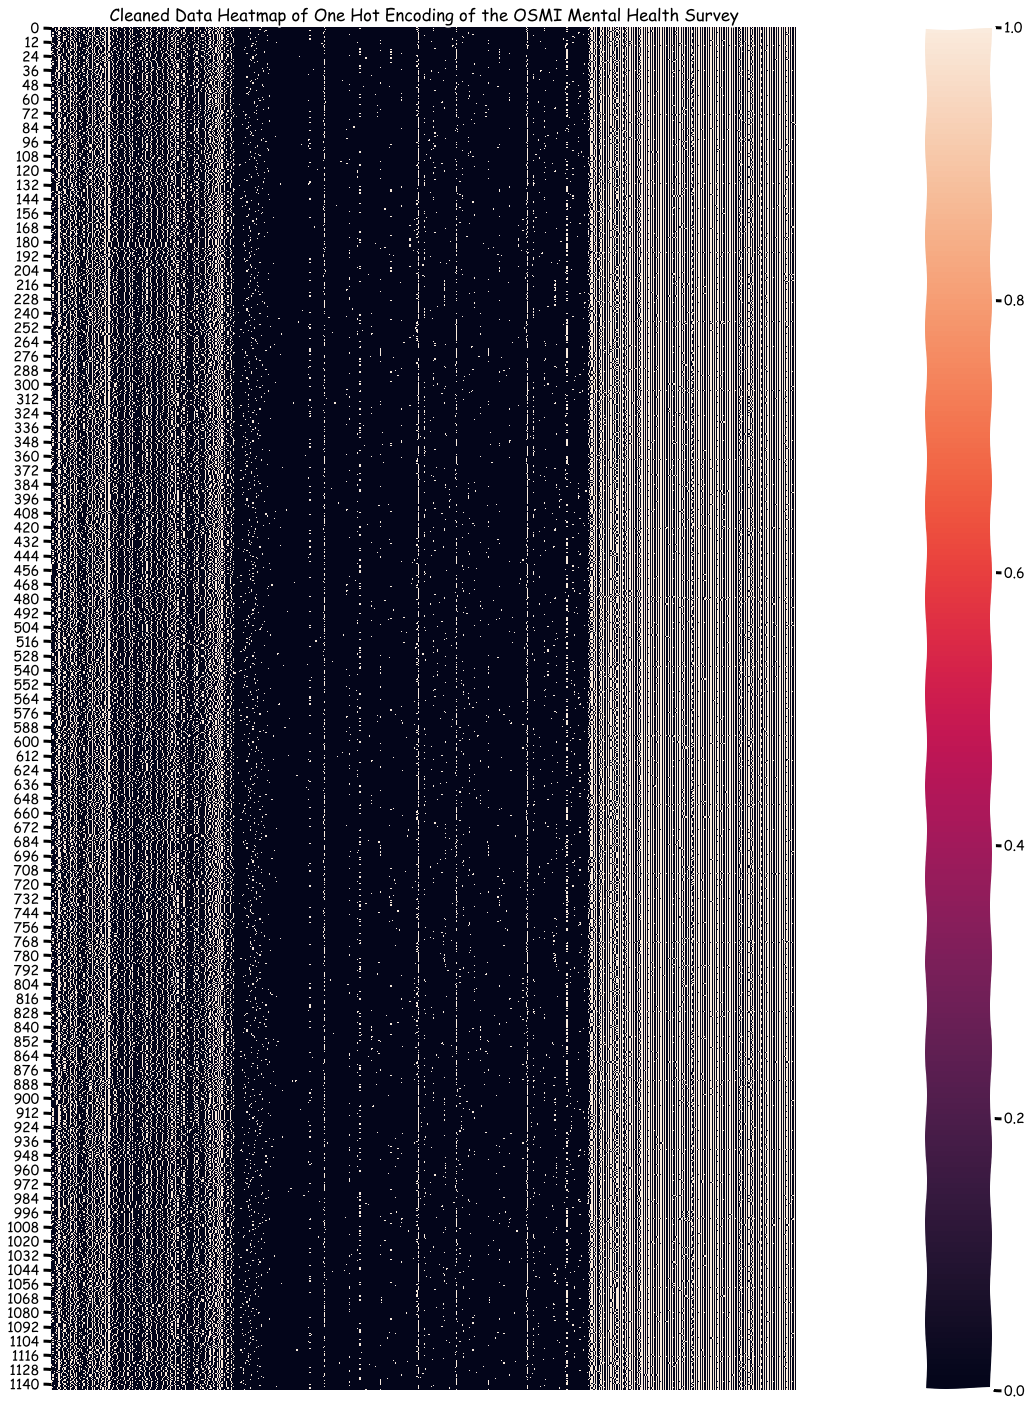

In [22]:
pylab.rcParams["figure.figsize"] = (autrDataEncoded.shape[0]/25, autrDataEncoded.shape[1]/25)
pylab.rcParams["font.size"] = 8.0

with plt.xkcd():
    sns.heatmap(autrDataEncoded, xticklabels=[], annot=False, square=True).set_title("Cleaned Data Heatmap of One Hot Encoding of the OSMI Mental Health Survey")

Pre processing complete :)

## Data Modelling

I'm interested in how mental health realtes to what types of jobs people have, so first I'm going to plot a histogram of the different types of jobs to check how stratified the sample is.

In [23]:
# positionTypes
positionTypesCounts = [autrData[t].value_counts()[True] for t in positionTypes] 

# selfDiagnosedYesTypes
selfDiagnosedYesTypesCounts = [autrData[t].value_counts()[True] for t in selfDiagnosedYesTypes] 

# selfDiagnosedMaybeTypes
selfDiagnosedMaybeTypesCounts = [autrData[t].value_counts()[True] for t in selfDiagnosedMaybeTypes] 

# professionalDiagnosedTypes
professionalDiagnosedTypesCounts = [autrData[t].value_counts()[True] for t in professionalDiagnosedTypes] 

In [24]:
print(positionTypesCounts)

[223, 148, 10, 601, 127, 11, 23, 59, 89, 228, 399, 82]


In [38]:
def plotHist(counts, keys, title):
    pylab.rcParams["figure.figsize"] = 24.0, 8.0
    pylab.rcParams["font.size"] = 24.0

    fig, ax = plt.subplots()

    rects1 = ax.bar(keys, counts, 0.5, alpha=0.5, color='b')
    ax.set_title(title)
    plt.xticks(rotation=90)

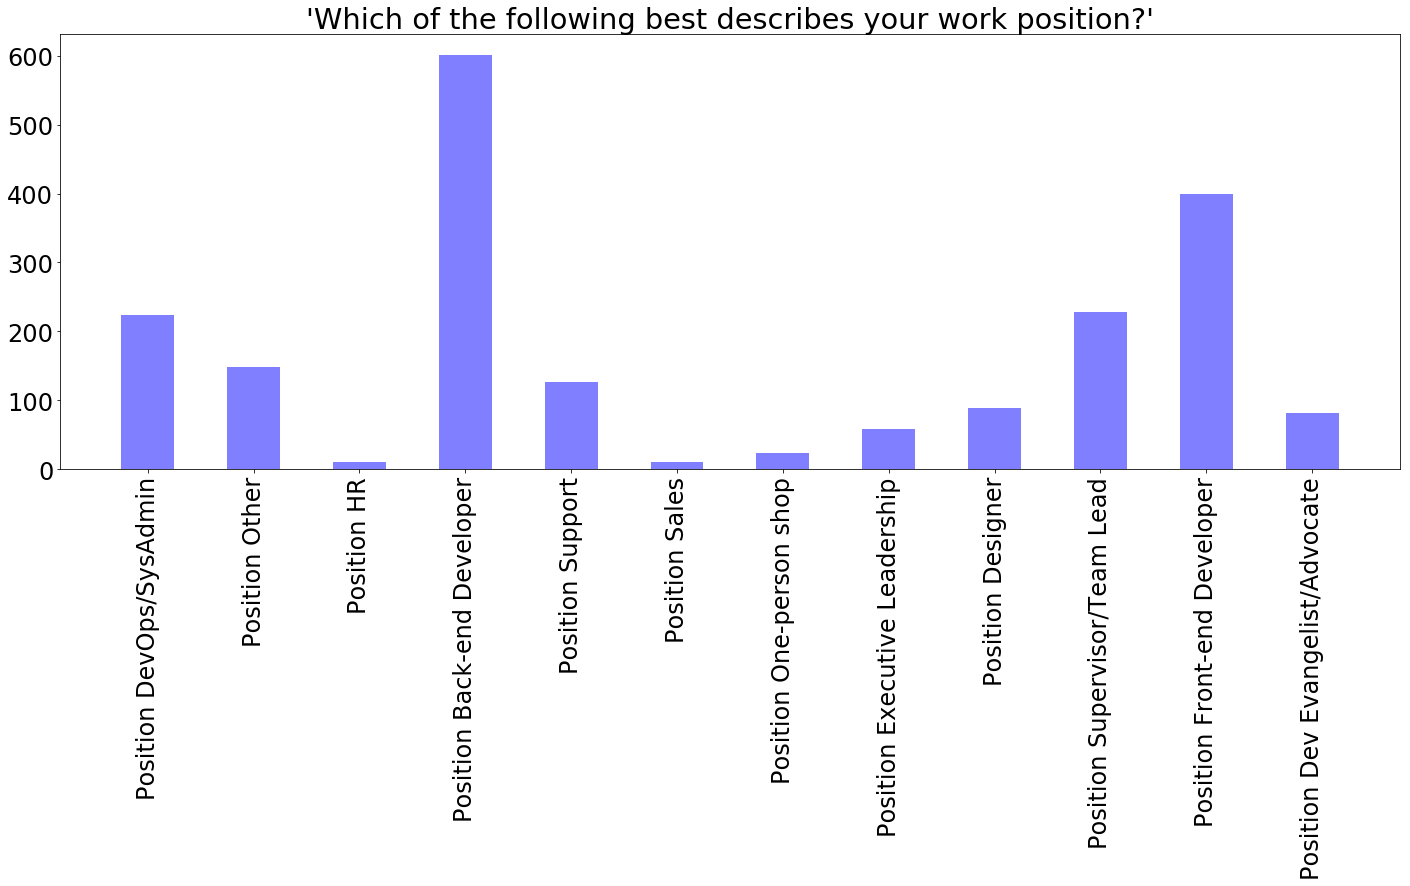

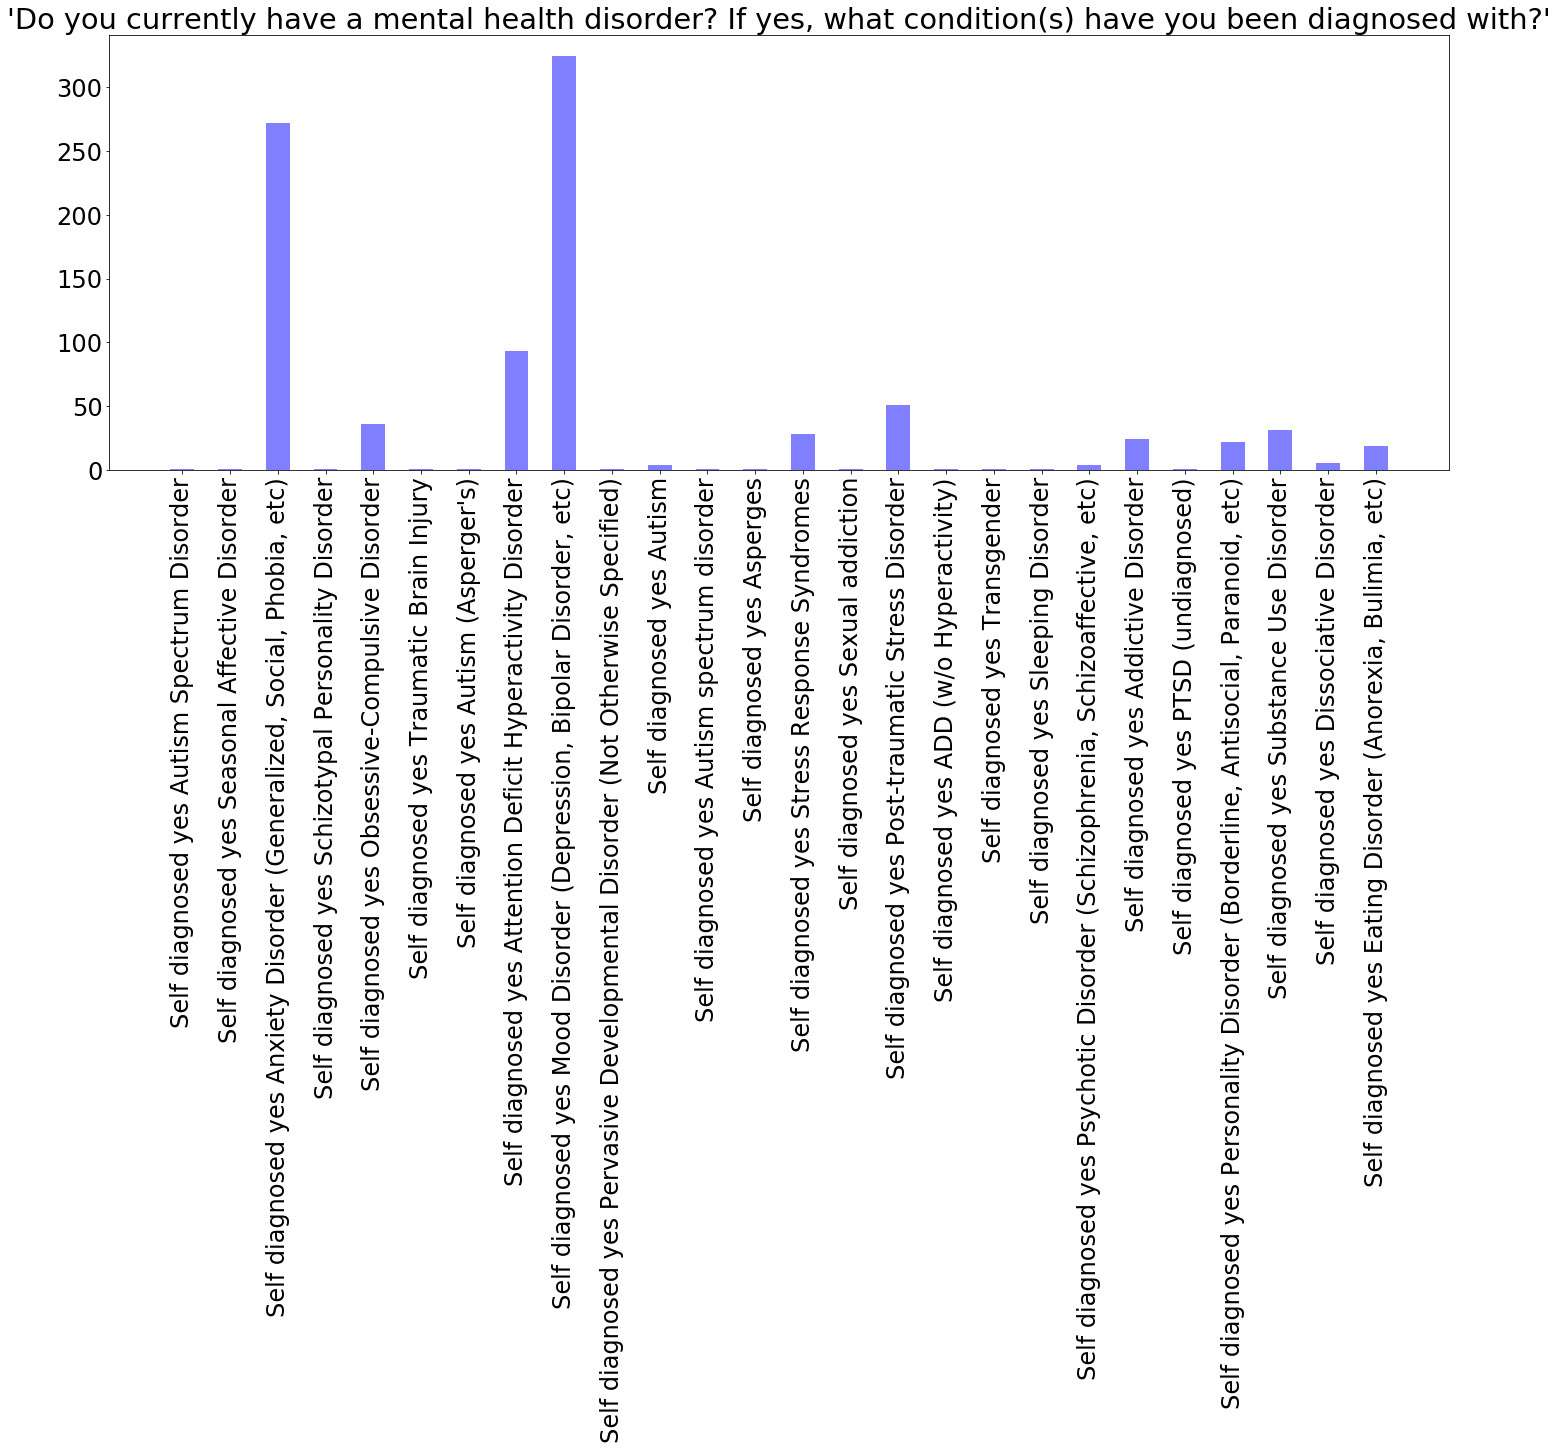

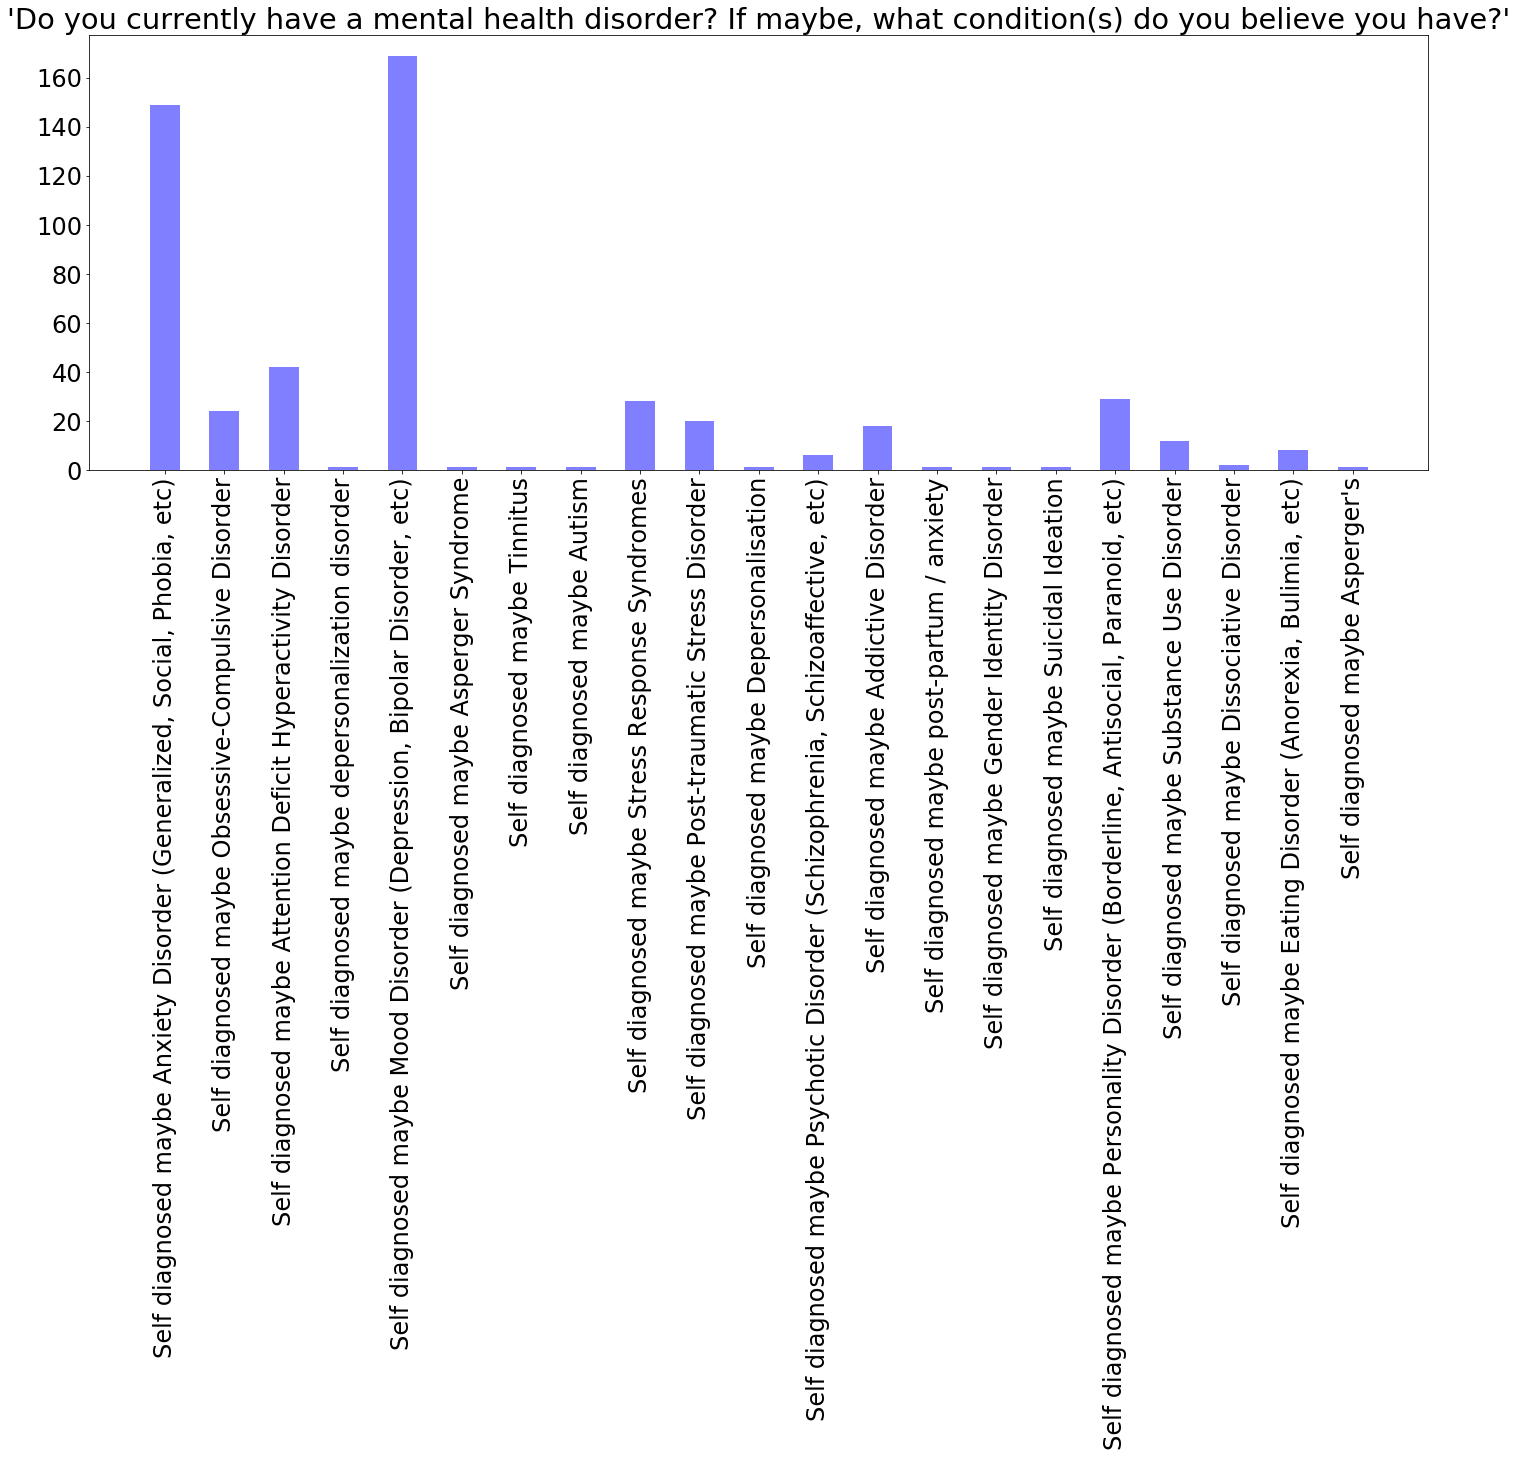

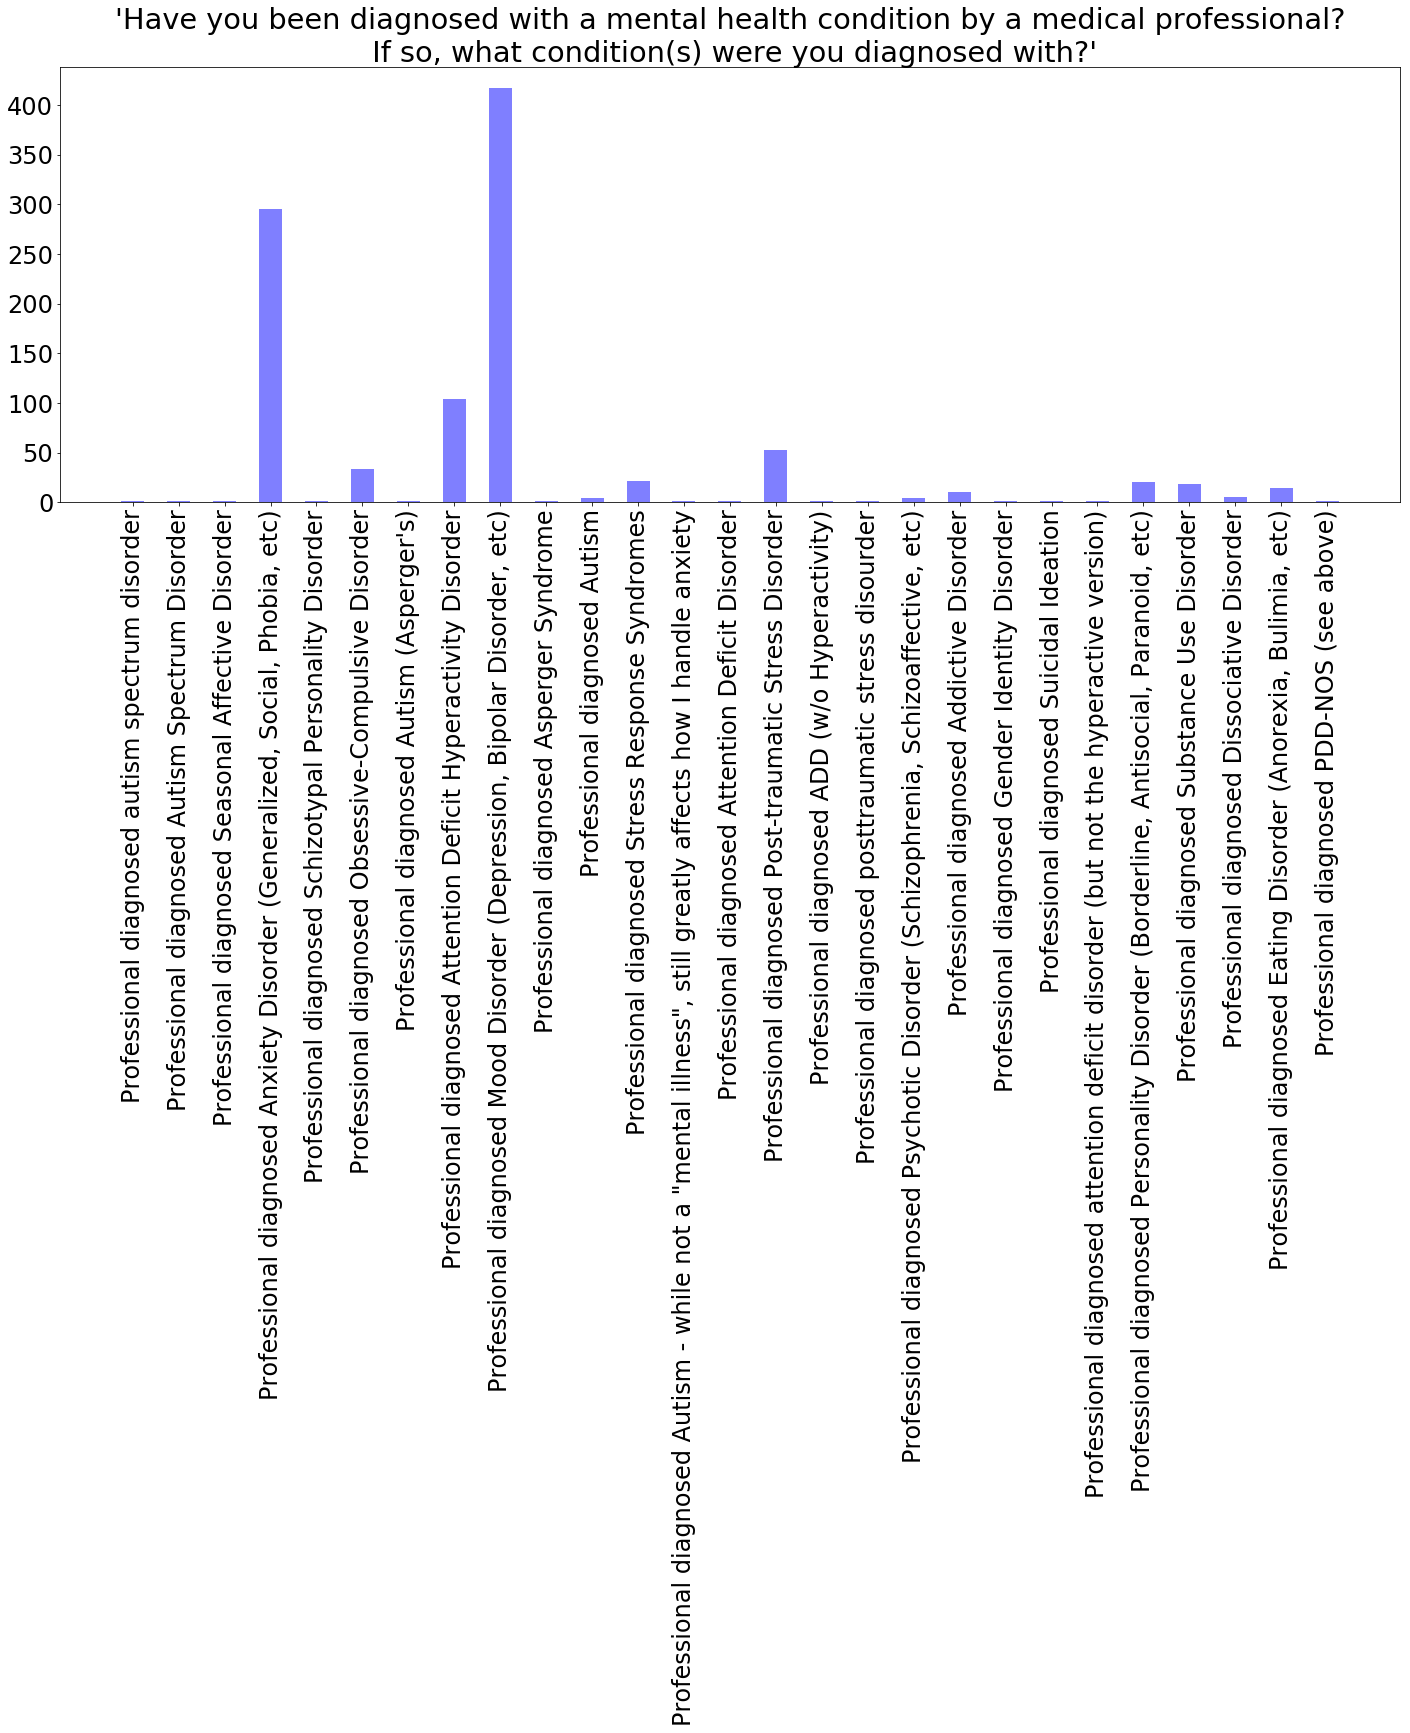

In [42]:
plotHist(positionTypesCounts, positionTypes, "'Which of the following best describes your work position?'")
plotHist(selfDiagnosedYesTypesCounts, selfDiagnosedYesTypes, "'Do you currently have a mental health disorder? If yes, what condition(s) have you been diagnosed with?'")
plotHist(selfDiagnosedMaybeTypesCounts, selfDiagnosedMaybeTypes, "'Do you currently have a mental health disorder? If maybe, what condition(s) do you believe you have?'")
plotHist(professionalDiagnosedTypesCounts, professionalDiagnosedTypes, "'Have you been diagnosed with a mental health condition by a medical professional?\n If so, what condition(s) were you diagnosed with?'")


In [82]:
def createTablePercentages(inpCounts, inpTypes, title=""):
    pd.options.display.max_colwidth = 100
    print(title)
    print("Total counts:", sum(inpCounts))
    data = []
    percentages = [i / sum(inpCounts) * 100 for i in inpCounts]
    for i, val in enumerate(inpTypes):
        data.append([val, inpCounts[i], percentages[i]])
        
    df = pd.DataFrame(data, columns=["Category", "Count", "Percentage"])
    df = df.sort_values(by=["Percentage"], ascending = False)
    return df

In [83]:
createTablePercentages(positionTypesCounts, positionTypes, "'Which of the following best describes your work position?'")

'Which of the following best describes your work position?'
Total counts: 2000


,Category,Count,Percentage
3,Position Back-end Developer,601,30.05
10,Position Front-end Developer,399,19.95
9,Position Supervisor/Team Lead,228,11.40
0,Position DevOps/SysAdmin,223,11.15
1,Position Other,148,7.40
4,Position Support,127,6.35
8,Position Designer,89,4.45
11,Position Dev Evangelist/Advocate,82,4.10
7,Position Executive Leadership,59,2.95
6,Position One-person shop,23,1.15


In [84]:
createTablePercentages(selfDiagnosedYesTypesCounts, selfDiagnosedYesTypes, "'Do you currently have a mental health disorder? If yes, what condition(s) have you been diagnosed with?'")

'Do you currently have a mental health disorder? If yes, what condition(s) have you been diagnosed with?'
Total counts: 927


,Category,Count,Percentage
8,"Self diagnosed yes Mood Disorder (Depression, Bipolar Disorder, etc)",325,35.059331
2,"Self diagnosed yes Anxiety Disorder (Generalized, Social, Phobia, etc)",272,29.341963
7,Self diagnosed yes Attention Deficit Hyperactivity Disorder,93,10.032362
15,Self diagnosed yes Post-traumatic Stress Disorder,51,5.501618
4,Self diagnosed yes Obsessive-Compulsive Disorder,36,3.883495
23,Self diagnosed yes Substance Use Disorder,31,3.344121
13,Self diagnosed yes Stress Response Syndromes,28,3.020496
20,Self diagnosed yes Addictive Disorder,24,2.588997
22,"Self diagnosed yes Personality Disorder (Borderline, Antisocial, Paranoid, etc)",22,2.373247
25,"Self diagnosed yes Eating Disorder (Anorexia, Bulimia, etc)",19,2.049622


In [85]:
createTablePercentages(selfDiagnosedMaybeTypesCounts, selfDiagnosedMaybeTypes, "'Do you currently have a mental health disorder? If maybe, what condition(s) do you believe you have?'")

'Do you currently have a mental health disorder? If maybe, what condition(s) do you believe you have?'
Total counts: 516


,Category,Count,Percentage
4,"Self diagnosed maybe Mood Disorder (Depression, Bipolar Disorder, etc)",169,32.751938
0,"Self diagnosed maybe Anxiety Disorder (Generalized, Social, Phobia, etc)",149,28.875969
2,Self diagnosed maybe Attention Deficit Hyperactivity Disorder,42,8.139535
16,"Self diagnosed maybe Personality Disorder (Borderline, Antisocial, Paranoid, etc)",29,5.620155
8,Self diagnosed maybe Stress Response Syndromes,28,5.426357
1,Self diagnosed maybe Obsessive-Compulsive Disorder,24,4.651163
9,Self diagnosed maybe Post-traumatic Stress Disorder,20,3.875969
12,Self diagnosed maybe Addictive Disorder,18,3.488372
17,Self diagnosed maybe Substance Use Disorder,12,2.325581
19,"Self diagnosed maybe Eating Disorder (Anorexia, Bulimia, etc)",8,1.550388


In [86]:
createTablePercentages(professionalDiagnosedTypesCounts, professionalDiagnosedTypes, "'Have you been diagnosed with a mental health condition by a medical professional?\n If so, what condition(s) were you diagnosed with?'")

'Have you been diagnosed with a mental health condition by a medical professional?
 If so, what condition(s) were you diagnosed with?'
Total counts: 1012


,Category,Count,Percentage
8,"Professional diagnosed Mood Disorder (Depression, Bipolar Disorder, etc)",417,41.205534
3,"Professional diagnosed Anxiety Disorder (Generalized, Social, Phobia, etc)",295,29.150198
7,Professional diagnosed Attention Deficit Hyperactivity Disorder,104,10.276680
14,Professional diagnosed Post-traumatic Stress Disorder,53,5.237154
5,Professional diagnosed Obsessive-Compulsive Disorder,33,3.260870
11,Professional diagnosed Stress Response Syndromes,21,2.075099
22,"Professional diagnosed Personality Disorder (Borderline, Antisocial, Paranoid, etc)",20,1.976285
23,Professional diagnosed Substance Use Disorder,18,1.778656
25,"Professional diagnosed Eating Disorder (Anorexia, Bulimia, etc)",14,1.383399
18,Professional diagnosed Addictive Disorder,10,0.988142


Let's create a decision tree relating to the different professions and the different disorders.